<a href="https://colab.research.google.com/github/Erickrus/llm/blob/main/AI_Paper_Highlighter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Paper Highlighter

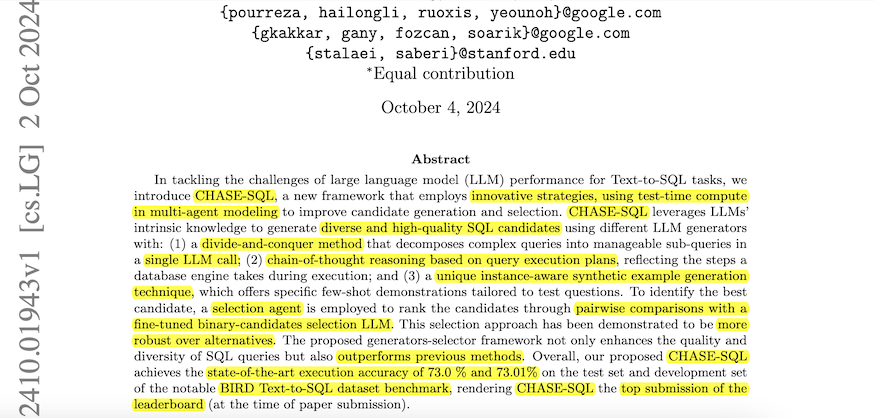

In [30]:
#@title parameter
PAPER_NAME = "2410.01943" #@param {type:"string"}

# download pdf file directly from https://arxiv.org/html/2410.01943 and save the pdf
import requests
url = f'https://arxiv.org/pdf/{PAPER_NAME}'
r = requests.get(url, allow_redirects=True)
# the name will be changed, how to get the name from arxiv?
FILE_NAME = r.headers['Content-Disposition'].split('filename=')[1]
FILE_NAME= FILE_NAME.strip('"')
open(FILE_NAME, 'wb').write(r.content)
print(f"FILE_NAME: {FILE_NAME}")

# FILE_NAME = "2410.01943v1.pdf" #@param {type:"string"}

HTML_FILENAME = FILE_NAME[:-4] + ".html"
PDF_FILENAME = FILE_NAME[:-4] + ".pdf"
HTML_OUT_FILENAME = FILE_NAME[:-4] + "_out.html"
PDF_OUT_FILENAME = FILE_NAME[:-4] + "_out.pdf"


print(f"HTML_FILENAME: {HTML_FILENAME}")
print(f"PDF_FILENAME: {PDF_FILENAME}")
print(f"HTML_OUT_FILENAME: {HTML_OUT_FILENAME}")
print(f"PDF_OUT_FILENAME: {PDF_OUT_FILENAME}")

PROMPT = f'''This is the entire paper in text:
Now can you mark the highlight tag for this paper ? highlight means something important in the key paragraph , they are key sentence or key phrase or words. using <highlight>...</highlight> to wrap them up. Make sure highlight is not the entire paragraph.
https://arxiv.org/html/{PAPER_NAME}

```
Please copy all text from https://arxiv.org/html/{PAPER_NAME}, and paste them here.
```
'''

print("\n\nPROMPT: \n"+PROMPT)

print("\n\nPlease access: https://x.com/i/grok")

FILE_NAME: 2410.01943v1.pdf
HTML_FILENAME: 2410.01943v1.html
PDF_FILENAME: 2410.01943v1.pdf
HTML_OUT_FILENAME: 2410.01943v1_out.html
PDF_OUT_FILENAME: 2410.01943v1_out.pdf


prompt: 
This is the entire paper in text:
Now can you mark the highlight tag for this paper ? highlight means something important in the key paragraph , they are key sentence or key phrase or words. using <highlight>...</highlight> to wrap them up. Make sure highlight is not the entire paragraph.
https://arxiv.org/html/2410.01943

```
Please copy all text from https://arxiv.org/html/2410.01943, and paste them here.
```



Please access: https://x.com/i/grok


In [ ]:
!pip install -q PyPDF2 pdfplumber pymupdf

In [31]:
#@title highlight.py
%%writefile highlight.py
def convert_highlights(input_file, output_file):
    try:
        # Read the input HTML file
        with open(input_file, 'r', encoding='utf-8') as file:
            content = file.read()

        # Replace <highlight> tags with span tags containing yellow background style
        converted_content = content.replace(
            '&lt;highlight&gt;',
            '<span style="background-color: yellow;">'
        ).replace(
            '&lt;/highlight&gt;',
            '</span>'
        )

        # Write the converted content to output file
        with open(output_file, 'w', encoding='utf-8') as file:
            file.write(converted_content)

        print(f"Conversion complete! Output saved to {output_file}")

    except FileNotFoundError:
        print(f"Error: Input file '{input_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Example usage
if __name__ == "__main__":
    import os,sys
    input_html = sys.argv[1]
    output_html = sys.argv[2]
    convert_highlights(input_html, output_html)


Overwriting highlight.py


In [32]:
#@title highlight_pdf.py
%%writefile highlight_pdf.py
import re
import fitz  # PyMuPDF
import sys
from typing import List
from bs4 import BeautifulSoup

def extract_highlighted_texts(html_file: str) -> List[str]:
    """Extract text between <highlight> and </highlight> markers, stripping nested HTML tags."""
    with open(html_file, 'r', encoding='utf-8') as f:
        html_content = f.read()
    # Use regex to find text between <highlight> and </highlight>
    pattern = r'&lt;highlight&gt;(.*?)&lt;/highlight&gt;'
    highlighted_texts = re.findall(pattern, html_content, re.DOTALL)
    # Strip nested HTML tags and clean up text
    cleaned_texts = []
    for text in highlighted_texts:
        # Parse with BeautifulSoup to remove HTML tags
        soup = BeautifulSoup(text, 'html.parser')
        cleaned_text = ' '.join(soup.get_text().split())  # Normalize whitespace
        if cleaned_text:
            cleaned_texts.append(cleaned_text)
    return cleaned_texts

def add_highlight_to_pdf(pdf_file: str, output_file: str, highlighted_texts: List[str]):
    """Add highlight annotations to the PDF for each highlighted text."""
    doc = fitz.open(pdf_file)
    highlights_added = False

    for target_text in highlighted_texts:
        found = False
        # Search each page for the target text
        for page_num in range(len(doc)):
            page = doc[page_num]
            # Search for the exact text (case-insensitive)
            rects = page.search_for(target_text, flags=fitz.TEXTFLAGS_SEARCH )
            if rects:
                # Highlight all found instances on this page
                for rect in rects:
                    annot = page.add_highlight_annot(rect)
                    if annot:
                        annot.update()
                        print(f"Highlighted text: '{target_text}' on page {page_num + 1} at coordinates "
                              f"({rect.x0:.2f}, {rect.y0:.2f}, {rect.x1:.2f}, {rect.y1:.2f})")
                        highlights_added = True
                found = True
        if not found:
            print(f"Warning: Could not find match for '{target_text}' in PDF. Skipping.")

    if highlights_added:
        doc.save(output_file, garbage=4, deflate=True)
        print(f"PDF with highlights saved to {output_file}")
    else:
        print("No highlights were added to the PDF.")

    doc.close()

def main(html_file: str, pdf_file: str, output_file: str):
    # Step 1: Extract highlighted texts from HTML
    highlighted_texts = extract_highlighted_texts(html_file)
    if not highlighted_texts:
        print("No highlighted texts found in HTML.")
        return

    # Step 2: Add highlights to PDF
    add_highlight_to_pdf(pdf_file, output_file, highlighted_texts)

if __name__ == "__main__":
    if len(sys.argv) != 4:
        print("Usage: python3 highlight_pdf.py input.html input.pdf output.pdf")
        sys.exit(1)

    html_file, pdf_file, output_file = sys.argv[1], sys.argv[2], sys.argv[3]
    main(html_file, pdf_file, output_file)

Overwriting highlight_pdf.py


In [33]:
!python3 highlight.py {HTML_FILENAME} {HTML_OUT_FILENAME}
!python3 highlight_pdf.py {HTML_FILENAME} {PDF_FILENAME} {PDF_OUT_FILENAME}

Conversion complete! Output saved to 2410.01943v1_out.html
Highlighted text: 'CHASE-SQL' on page 1 at coordinates (75.36, 110.36, 181.41, 127.58)
Highlighted text: 'CHASE-SQL' on page 1 at coordinates (138.52, 348.63, 192.40, 357.67)
Highlighted text: 'CHASE-SQL' on page 1 at coordinates (393.43, 359.58, 447.37, 368.63)
Highlighted text: 'CHASE-SQL' on page 1 at coordinates (461.34, 458.20, 515.38, 467.26)
Highlighted text: 'CHASE-SQL' on page 1 at coordinates (357.97, 480.22, 410.53, 489.15)
Highlighted text: 'CHASE-SQL' on page 2 at coordinates (458.39, 504.38, 516.57, 514.34)
Highlighted text: 'CHASE-SQL' on page 3 at coordinates (224.82, 244.77, 282.31, 254.74)
Highlighted text: 'CHASE-SQL' on page 3 at coordinates (229.22, 480.93, 283.26, 489.98)
Highlighted text: 'CHASE-SQL' on page 7 at coordinates (267.57, 116.19, 323.69, 126.15)
Highlighted text: 'CHASE-SQL' on page 7 at coordinates (373.74, 246.15, 430.43, 256.11)
Highlighted text: 'CHASE-SQL' on page 7 at coordinates (151.00